### Создадим Dataloader и подготовим функции для препроцессинга

In [1]:
import torch
import numpy as np
import torchvision
from torchvision.models import resnet34
from Model import *
from IPython import display

In [2]:
from torch.utils.data import DataLoader, Dataset
from random import randint
import os
from PIL import Image, ImageDraw
import numpy as np
from torch.utils.data import Dataset , DataLoader

class Data(Dataset):
    def __init__(self, file_paths, results, transform = None):
        self.paths = file_paths
        self.results = results 
        self.transform = transform
        
        self.target = []
        position = 0
        self.imgs = []
        for path in self.paths :
            files = os.listdir(path)
            for file in files : 
                self.imgs += [path + file]
            self.target += [self.results[position]]*len(files)
            position += 1
        
    def __len__(self):
        return len(self.target)
        
    def __getitem__(self, ind):     
        img  =  self.imgs[ind] 
        data = np.array(Image.open(f"{img}").convert("RGB"))
        
        #print(str(position) + " ended")
               
        sample = {'image': np.array(data), 'landmarks': np.array(self.target[ind])}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
                      


In [3]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [4]:
from torchvision import transforms
from skimage import  transform
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(700),
                               RandomCrop(512),
                               ToTensor()])

### Загрузим тренировочные данные

In [5]:
transformed_dataset = Data(["Datasets/train/Nazi/","Datasets/train/Tinkoff/", "Datasets/train/Normal/"], [[1., 0.], [0., 1.], [0., 0.]],
                                           transform = composed)
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

ValidDataset = Data(["Datasets/validation/Nazi/","Datasets/validation/Tinkoff/", "Datasets/validation/Normal/"], [[1., 0.], [0., 1.], [0., 0.]],
                                           transform = composed)
dataValidLoader = DataLoader(ValidDataset, shuffle=True, num_workers=4, batch_size=4)

### Будем обучать на видеокарте

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Загружаем модель

In [7]:
from Model import PulseContentModel
from torchvision.models import resnet34
model = PulseContentModel().float()
model.to(device)
optimizer = torch.optim.Adagrad(model.parameters())


### Создаем папку для графиков, создаем ыункцию для отрисовки графиков

In [9]:
!rm -r graphs

In [10]:
!mkdir graphs

In [11]:
!ls

Datasets		  __pycache__	  pymp-6xswyq34  pymp-uv28os_4
Model.py		  graphs	  pymp-9zhdn6il  trainOnlyNaziGraphs
ModelWeight		  notebook.ipynb  pymp-kb9glwju  utils.py
NaziClassification.ipynb  pymp-2ntqgg74   pymp-n8pnk_15  weightsTinkoff
README.md		  pymp-4f3rp4g2   pymp-oveww6uf


In [8]:
def plotGraphs(AverageTrueN, AveragePredN, AverageTrueT, AveragePredT, epoch, flag , name = 'graphs', needSave = False):
    maxT = max(AveragePredT)
    maxN = max(AveragePredN)
    minT = min(AveragePredT)
    minN = min(AveragePredN)
    precisionN, recallN, thresholdsN = precision_recall_curve( AverageTrueN.astype(int), AveragePredN )
    precisionT, recallT, thresholdsT = precision_recall_curve( AverageTrueT.astype(int), AveragePredT )
    
    actN = np.linspace(0,1,1000)[:-1]
    actT = np.linspace(0,1,1000)[:-1]
    accuracyN = [sum((AveragePredN > act_i).astype(int)  == AverageTrueN)/len(AverageTrueN) for act_i in actN]
    accuracyT = [sum((AveragePredT > act_i).astype(int)  == AverageTrueT)/len(AverageTrueN) for act_i in actT]
    
    f1, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.plot(recallN, precisionN)
    ax1.set_title('Nazi')
    ax1.set_ylabel('precision')
    ax1.set_xlabel('recall')
    
    ax2.plot(recallT, precisionT)
    ax2.set_title('Tinkoff')
    ax2.set_ylabel('precision')
    ax2.set_xlabel('recall')

    f1.set_size_inches(8, 5)
    if needSave :
        f1.savefig(name + "/epoch_" + str(epoch) + flag + " PR")
    
    f2, (ax3, ax4) = plt.subplots(1, 2, sharey=True)

    ax3.plot(actN,accuracyN)
    ax3.set_title('Accuracy N')
    ax3.set_xlabel('activation')
    ax4.set_ylabel('accuracy')
    
    ax4.plot(actT,accuracyT)
    ax4.set_title('Accuracy T')
    ax4.set_xlabel('activation')
    ax4.set_ylabel('accuracy')
    f2.set_size_inches(8, 5)
    if needSave:
        f2.savefig(name + "/epoch_" + str(epoch) + flag + " Accuracy")
    plt.show()

    

### Обучаем

epoch : 60 finished Average Loss : 0.08827881893869173


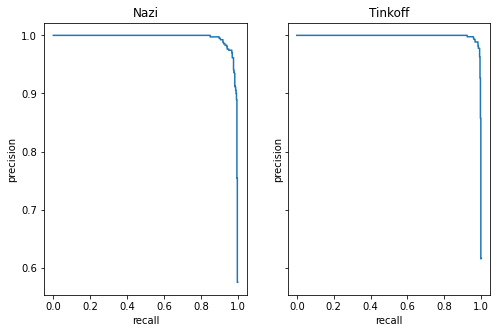

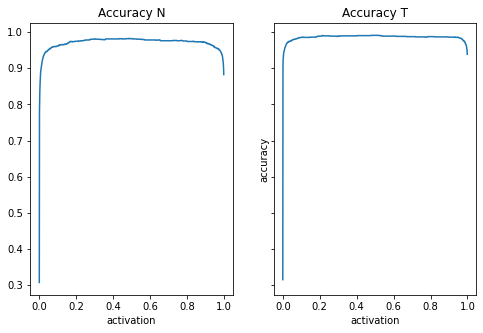

for validation


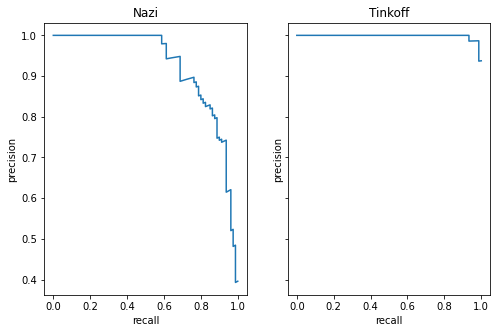

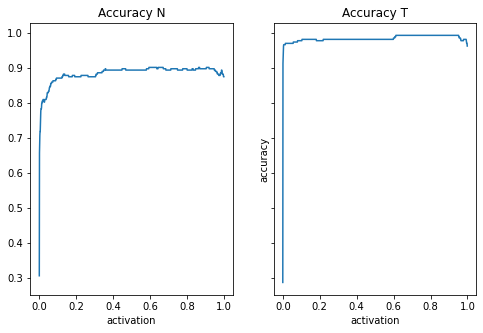

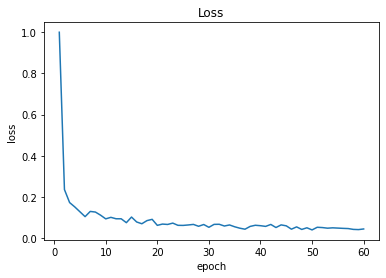

In [32]:
#from torch.nn.functional import binary_cross_entropy as entropy
#from torch.nn import BCEWithLogitsLoss as entropy
import torch.nn.functional as F
from torch.nn.functional import cross_entropy 
import scikitplot as skplt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

import warnings
import torch.nn as nn
lossFuct = nn.BCEWithLogitsLoss()
warnings.filterwarnings('ignore')

datalen = transformed_dataset.__len__()

epochs = 60
LossArray = []

for epoch_index in range(epochs):
    AverageLoss = 0
    step = 0
    
    
    AverageTrueN = np.array([])
    AveragePredN = np.array([])
    AverageTrueT = np.array([])
    AveragePredT = np.array([])
    for batch in dataloader:
        
        optimizer.zero_grad()
        predN, predT = model.forward(batch['image'].to(device).float())
        predN = predN.to(device)
        predT = predT.to(device)
        loss = lossFuct(predN[:,0].float(), batch['landmarks'].to(device).float()[:,0]) + lossFuct(predT[:,0].float(), batch['landmarks'].to(device).float()[:,1])
        
        

        
        loss.backward()
        optimizer.step()     
        
        
        predN = F.sigmoid(predN)
        predT = F.sigmoid(predT)
        AverageLoss += loss
        step += 1
        
        
        
        AveragePredN = np.append(AveragePredN, predN.cpu().detach().numpy())
        AverageTrueN = np.append(AverageTrueN, batch['landmarks'].cpu().int().numpy()[:,0])
        AveragePredT = np.append(AveragePredT, predT.cpu().detach().numpy())
        AverageTrueT = np.append(AverageTrueT, batch['landmarks'].cpu().int().numpy()[:,1])
        
        # для дебага
        #if step == 4:
        #    break
        
    
    
    stepVal = 0
    ValpredN = np.array([])
    ValtrueN = np.array([])
    ValpredT = np.array([])
    ValtrueT = np.array([])
    for batch in dataValidLoader:
        
        stepVal += 1
        predN, predT = model.forward(batch['image'].to(device).float())
        predN = predN.to(device)
        predT = predT.to(device)
        predN = F.sigmoid(predN)
        predT = F.sigmoid(predT)
        
        
        ValpredN = np.append(ValpredN, predN.cpu().detach().numpy())
        ValtrueN = np.append(ValtrueN, batch['landmarks'].cpu().int().numpy()[:,0])
        ValpredT = np.append(ValpredT, predT.cpu().detach().numpy())
        ValtrueT = np.append(ValtrueT, batch['landmarks'].cpu().int().numpy()[:,1])
        
        # для дебага
        #№if stepVal == 4:
        #       break
        
    display.clear_output()
    print("epoch : " + str(epoch_index + 1) + " finished" + " Average Loss : " + str(AverageLoss.item()/step))
    LossArray += [min(AverageLoss.item()/(2*step), 1)]
    plotGraphs(AverageTrueN, AveragePredN, AverageTrueT, AveragePredT, epoch_index, " Train")
    print("for validation")
    plotGraphs(ValtrueN, ValpredN, ValtrueT, ValpredT, epoch_index, " Test")
    f1,ax1 = plt.subplots()
    ax1.plot(range(1, len(LossArray) + 1), LossArray) 
    ax1.set_title('Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    plt.show()

    


In [ ]:
f1,ax1 = plt.subplots()
ax1.plot(range(1, len(LossArray) + 1), LossArray) 
ax1.set_title('Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
plt.show()

### Сохраняем/загружаем  веса модели

In [33]:
#torch.save(model.state_dict(), 'ModelWeight')

In [9]:
#model.load_state_dict(torch.load('ModelWeight'))


<All keys matched successfully>

In [ ]:
!ls Datasets

### Проверим модель 

/home/Katerina5649/Pulse/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/Katerina5649/Pulse/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


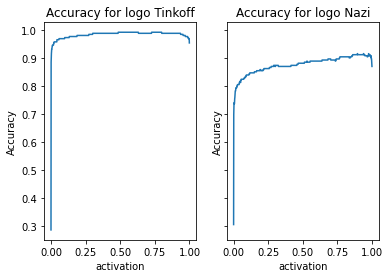

Accuracy 0.916030534351145


In [10]:
import torch.nn.functional as F
from torch.nn.functional import cross_entropy 
import scikitplot as skplt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

transformed_TestDataset = Data(["Datasets/test/Tinkoff/", "Datasets/test/Normal/", "Datasets/test/Nazi/"], [[0., 1.], [0., 0.], [1., 0.]],
                                           transform = composed)
dataTestLoader = DataLoader(transformed_TestDataset, batch_size=1,
                        shuffle=True)


AveragePredT = np.array([])
AverageTrueT = np.array([])
AveragePredN = np.array([])
AverageTrueN = np.array([])

for batch in dataValidLoader:
    predN, predT = model.forward(batch['image'].to(device).float())
    predN = predN.to(device)
    predT = predT.to(device)
    predN = F.sigmoid(predN)
    predT = F.sigmoid(predT)
    #print(batch['landmarks'].cpu().int().numpy()[:,1])
    AveragePredT = np.append(AveragePredT, predT.cpu().detach().numpy())
    AverageTrueT = np.append(AverageTrueT, batch['landmarks'].cpu().int().numpy()[:,1])
    
    AveragePredN = np.append(AveragePredN, predN.cpu().detach().numpy())
    AverageTrueN = np.append(AverageTrueN, batch['landmarks'].cpu().int().numpy()[:,0])
    
actT = np.linspace(0,1,1000)[:-1]
accuracyT = [sum((AveragePredT > act_i).astype(int)  == AverageTrueT)/len(AverageTrueT) for act_i in actT]

actN = np.linspace(0,1,1000)[:-1]
accuracyN = [sum((AveragePredN > act_i).astype(int)  == AverageTrueN)/len(AverageTrueN) for act_i in actN]
    
    
f1,(ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(actT, accuracyT) 
ax1.set_title('Accuracy for logo Tinkoff')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('activation')

ax2.plot(actN, accuracyN) 
ax2.set_title('Accuracy for logo Nazi')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('activation')
plt.show()
print("Accuracy " + str(max(accuracyN)))
    


## Тест для логотипа

In [15]:
## найдем на каких картинках ошибается
act = actT[np.argmax(accuracyT)]

step = 0
wrong = 0
for batch in dataTestLoader:  
    predN, predT = model.forward(batch['image'].to(device).float())
    predT = predT.to(device)
    predT = F.sigmoid(predT)[0]
    if ((predT > act).cpu().int().item() != batch['landmarks'].cpu().int().numpy()[:,1][0]):
        img = Image.open(f"{transformed_TestDataset.imgs[step]}").convert("RGB")
        img.show()
        print(transformed_TestDataset.imgs[step])
        wrong += 1
    step += 1
        

print("accuracy = " + str((step - wrong)/step))
    


Datasets/test/Tinkoff/images (3).jpeg
Datasets/test/Tinkoff/lplplplp.jpeg
Datasets/test/Normal/download (13).jpeg
Datasets/test/Normal/joj[.jpeg
Datasets/test/Normal/eqf.jpeg
Datasets/test/Normal/images (1).jpeg
Datasets/test/Normal/download (14).jpeg
Datasets/test/Nazi/download (1).jpeg
accuracy = 0.9175257731958762


## Тест для свастики

In [16]:
## найдем на каких картинках ошибается
act = actN[np.argmax(accuracyN)]

step = 0
wrong = 0
for batch in dataTestLoader:
    predN, predT = model.forward(batch['image'].to(device).float())
    predN = predN.to(device)
    predN = F.sigmoid(predN)[0]
    if ((predN > act).cpu().int().item() != batch['landmarks'].cpu().int().numpy()[:,0][0]):
        img = Image.open(f"{transformed_TestDataset.imgs[step]}").convert("RGB")
        img.show()
        print(transformed_TestDataset.imgs[step])
        wrong += 1
    step += 1
        

print("accuracy = " + str((step - wrong)/step))

Datasets/test/Tinkoff/download (1).png
Datasets/test/Tinkoff/okoko.png
Datasets/test/Tinkoff/images (3).png
Datasets/test/Tinkoff/images (7).jpeg
Datasets/test/Tinkoff/images.jpeg
Datasets/test/Normal/cxv.jpeg
Datasets/test/Normal/joj[.jpeg
Datasets/test/Normal/images (2).jpeg
Datasets/test/Normal/download (12).jpeg
Datasets/test/Normal/eqf.jpeg
Datasets/test/Normal/uj.jpeg
Datasets/test/Normal/download (2).jpeg
Datasets/test/Normal/download (15).jpeg
Datasets/test/Nazi/images (3).jpeg
Datasets/test/Nazi/download.png
accuracy = 0.845360824742268
